In [ ]:
import praw
import pandas as pd

# Reddit API Credentials
reddit = praw.Reddit(
    client_id="_9aT35rxVcBiNC17_Al5_g",
    client_secret="tyas9JGsMfhm4Jhifg86JnvpHZHx6A",
    user_agent="CryptoSentimentApp"
)
def fetch_reddit_posts(coin, num_posts):
    """
    Fetches Reddit posts related to a cryptocurrency and returns data in a Pandas DataFrame.
    
    Parameters:
    - coin (str): The cryptocurrency to search for.
    - num_posts (int): Number of posts to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing post details.
    """
    subreddit = reddit.subreddit("cryptocurrency")
    query = coin.lower()  
    
    
    posts_data = []
    for post in subreddit.search(query, limit=num_posts):
        posts_data.append([
            post.id,
            post.title,
            post.selftext,  # Post content
            post.score,  # Upvotes
            post.num_comments,  # Number of comments
            post.url,  # Post link
            post.created_utc  # Timestamp
        ])

    
    df = pd.DataFrame(posts_data, columns=["Post_ID", "Title", "Content", "Upvotes", "Comments", "URL", "Timestamp"])
    return df


df_bitcoin_1000 = fetch_reddit_posts("Bitcoin", 1000)
print(df_bitcoin_1000.head())
print(df_bitcoin_1000.shape)
df_bitcoin_1000.to_csv('csv_bitcoin_1000.csv')


ModuleNotFoundError: No module named 'praw'

In [3]:
import pandas as pd
import re
from datetime import datetime

def clean_reddit_data(df):
    """
    Cleans Reddit dataset by fixing inconsistencies, formatting text, and removing duplicates.
    
    Parameters:
    - df (pd.DataFrame): Raw Reddit dataset
    
    Returns:
    - pd.DataFrame: Cleaned dataset
    """
    
    # Fix Data Inconsistencies (Convert Timestamp, Standardize Column Names)
    df = df.copy()
    df.columns = df.columns.str.lower().str.replace(" ", "_")  # Standardize column names
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")  # Convert UNIX timestamp to datetime
    
    # Uniform Formatting (Lowercasing & Removing Special Characters)
    def clean_text(text):
        if isinstance(text, str):
            text = text.lower()  # Convert to lowercase
            text = re.sub(r"http\S+", "", text)  # Remove URLs
            text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
            text = text.strip()  # Remove leading/trailing spaces
        return text

    df["title"] = df["title"].apply(clean_text)
    df["content"] = df["content"].apply(clean_text)
    
    # Remove Duplicates
    df.drop_duplicates(subset=["title"], inplace=True)  # Remove duplicate titles
    df.drop_duplicates(subset=["url"], inplace=True)  # Remove duplicate URLs

    df = df.drop(columns=["unnamed:_0"])

    return df

df_bitcoin_1000 = pd.read_csv('csv_bitcoin_1000.csv')  # Load the dataset
df_clean_bitcoin_1000 = clean_reddit_data(df_bitcoin_1000)  # Clean the dataset
print(df_clean_bitcoin_1000.head())  # Display cleaned data

df_clean_bitcoin_1000.to_csv('csv_clean_bitcoin_1000.csv')


   post_id                                              title  \
0  1gqafju  bitcoin has followed a consistent 4year cycle ...   
1  1iq3fe9           me in 2009 instead of buying bitcoin btc   
2  1h6yoqp  on february 9th 2011 bitcoin first touched 1 l...   
3  1ik2qgu  explaining bitcoin 12 years ago when it was wo...   
4  1hbsf6a  this anonymous guy received 50 worth of bitcoi...   

                        content  upvotes  comments  \
0                           NaN     3576       700   
1                           NaN    17790       310   
2                           NaN     7832       495   
3                           NaN     8423       293   
4  imagine hodling for 13 years     7417       452   

                                    url           timestamp  
0  https://i.redd.it/95px1ns8in0e1.jpeg 2024-11-13 11:04:46  
1   https://i.redd.it/denbcysakbje1.png 2025-02-15 15:13:54  
2   https://i.redd.it/m7ll0go40y4e1.png 2024-12-05 02:39:33  
3   https://i.redd.it/hd0ul5cglrhe1.

🔹 Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  235 non-null    int64 
 1   post_id     235 non-null    object
 2   title       235 non-null    object
 3   content     59 non-null     object
 4   upvotes     235 non-null    int64 
 5   comments    235 non-null    int64 
 6   url         235 non-null    object
 7   timestamp   235 non-null    object
dtypes: int64(3), object(5)
memory usage: 14.8+ KB
None

🔹 Descriptive Statistics:
       Unnamed: 0       upvotes     comments
count  235.000000    235.000000   235.000000
mean   117.000000   4864.051064   742.634043
std     67.982841   5182.244215   733.138624
min      0.000000    429.000000    88.000000
25%     58.500000   1375.500000   272.500000
50%    117.000000   3060.000000   531.000000
75%    175.500000   6186.500000   979.000000
max    234.000000  38841.000

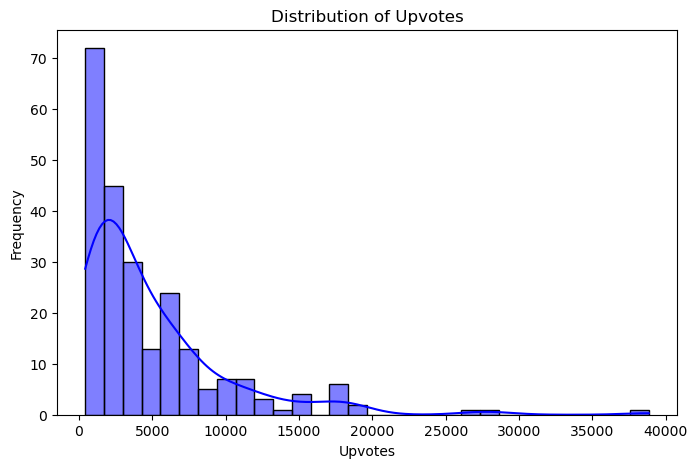

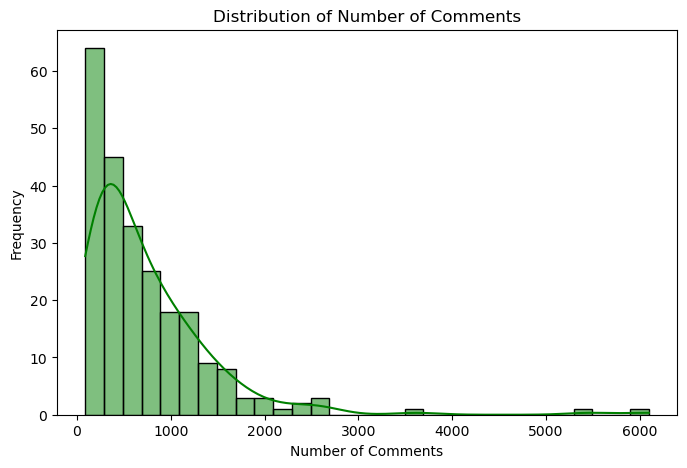

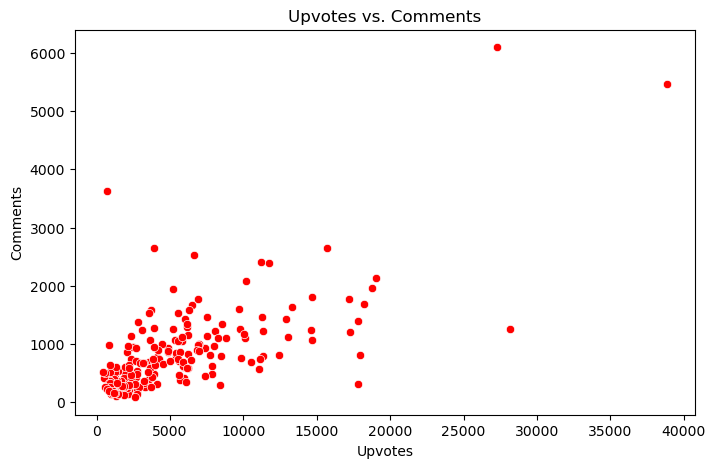

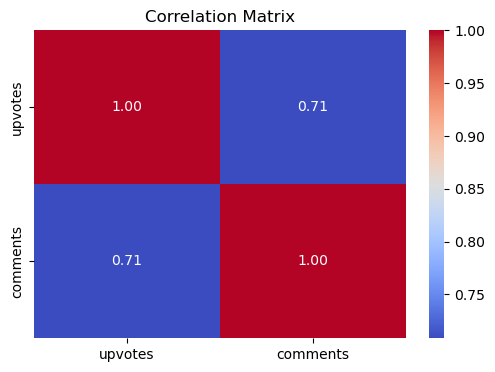

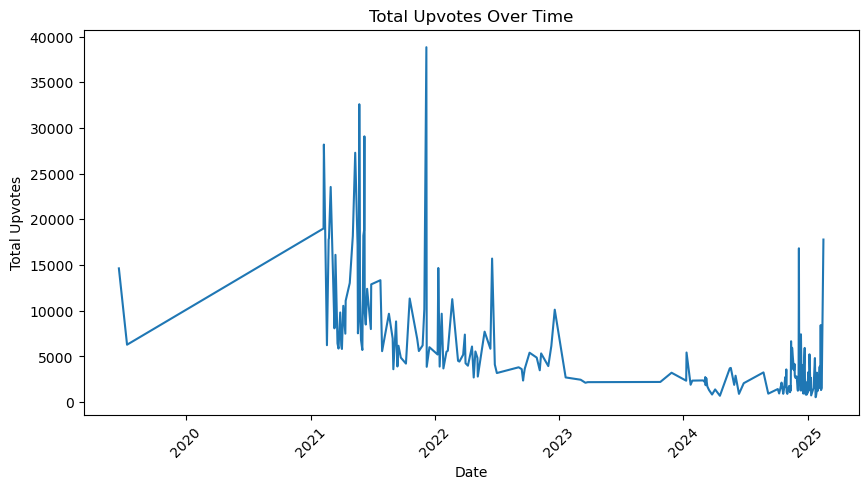


🔹 Initial Insights:
- Most posts have low upvotes, but some viral posts get extreme engagement.
- Comment count and upvotes seem to have a positive correlation.
- Distribution plots indicate possible outliers in high upvotes/comments.


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#load cleaned dataset
df_clean_bitcoin_1000 = pd.read_csv('csv_clean_bitcoin_1000.csv') 

def preprocess_data(df):
    """
    Performs some data pre-processing with feature transformation, and scaling.
    
    Parameters:
    - df (pd.DataFrame): Cleaned dataset

    Returns:
    - None (Displays head of data)
    """
    print("🔹 Initial Data Overview:")
    print(df.info())
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Extract time-based features
    df['hour'] = df['timestamp'].dt.hour  # hour posted
    df['day_of_week'] = df['timestamp'].dt.dayofweek  # day of week (0 = Monday, 6 = Sunday)
    
    # Create new features (length of title, content, and creates an engagement score)
    df['title_length'] = df['title'].apply(lambda x: len(str(x)))  
    df['content_length'] = df['content'].apply(lambda x: len(str(x)))  
    df['engagement_score'] = df['upvotes'] * 0.4 + df['comments'] * 0.6
    
    # Normalize numerical features
    scaler = MinMaxScaler()
    df[['upvotes', 'comments', 'title_length', 'content_length', 'engagement_score']] = scaler.fit_transform(
        df[['upvotes', 'comments', 'title_length', 'content_length', 'engagement_score']]
    )
    
    print("🔹 Preprocessing Complete. Data Sample:")
    print(df.head())
    return df

def perform_eda(df):
    """
    Performs exploratory data analysis (EDA) on a cleaned Reddit dataset.
    
    Parameters:
    - df (pd.DataFrame): Cleaned dataset

    Returns:
    - None (Displays graphs and prints insights)
    """
    df = preprocess_data(df)

    # Summary Statistics
    print("🔹 Dataset Overview:")
    print(df.info())  # Data types & missing values
    print("\n🔹 Descriptive Statistics:")
    print(df.describe())  # Numeric column stats (upvotes, comments)

    # Distribution of Upvotes
    plt.figure(figsize=(8, 5))
    sns.histplot(df["upvotes"], bins=30, kde=True, color="blue")
    plt.title("Distribution of Upvotes")
    plt.xlabel("Upvotes")
    plt.ylabel("Frequency")
    plt.show()

    # Distribution of Comments
    plt.figure(figsize=(8, 5))
    sns.histplot(df["comments"], bins=30, kde=True, color="green")
    plt.title("Distribution of Number of Comments")
    plt.xlabel("Number of Comments")
    plt.ylabel("Frequency")
    plt.show()

    # Relationship Between Upvotes & Comments
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df["upvotes"], y=df["comments"], color="red")
    plt.title("Upvotes vs. Comments")
    plt.xlabel("Upvotes")
    plt.ylabel("Comments")
    plt.show()

    # Correlation Heatmap
    numeric_df = df.select_dtypes(include=['number'])

    plt.figure(figsize=(6, 4))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()

    # Time-Based Analysis
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df['day_of_week'], y=df['engagement_score'], palette="coolwarm")
    plt.title("Engagement Score by Posted Day of the Week")
    plt.xlabel("Day of the Week (0 = Monday, 6 = Sunday)")
    plt.ylabel("Engagement Score")
    plt.show()

    # Correlation Heatmap for Engagement Score & Text Features
    plt.figure(figsize=(6, 4))
    sns.heatmap(df[["engagement_score", "title_length", "content_length"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix: Engagement Score & Text Features")
    plt.show()
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["date"] = df["timestamp"].dt.date

    plt.figure(figsize=(10, 5))
    df.groupby("date")["upvotes"].sum().plot()
    plt.title("Total Upvotes Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Upvotes")
    plt.xticks(rotation=45)
    plt.show()


    # Interpretation of Findings
    print("\n🔹 Initial Insights:")
    print("- Most posts have low upvotes, but some viral posts get extreme engagement.")
    print("- Comment count and upvotes seem to have a positive correlation.")
    print("- Distribution plots indicate possible outliers in high upvotes/comments.")
    print("- Neither title length or content length strongly correlate to engagement score here.")



# Example Usage
perform_eda(df_clean_bitcoin_1000)


In [2]:
import pandas as pd

df = pd.read_csv("csv_clean_bitcoin_1000.csv")

if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

df["content"].fillna("No content", inplace=True)

df["timestamp"] = pd.to_datetime(df["timestamp"])

df.to_csv("csv_clean_bitcoin_1000.csv", index=False)

print("Data Cleaning")
print(df.info())
print(df.head())


Data Cleaning
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   post_id    235 non-null    object        
 1   title      235 non-null    object        
 2   content    235 non-null    object        
 3   upvotes    235 non-null    int64         
 4   comments   235 non-null    int64         
 5   url        235 non-null    object        
 6   timestamp  235 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 13.0+ KB
None
   post_id                                              title  \
0  1gqafju  bitcoin has followed a consistent 4year cycle ...   
1  1iq3fe9           me in 2009 instead of buying bitcoin btc   
2  1h6yoqp  on february 9th 2011 bitcoin first touched 1 l...   
3  1ik2qgu  explaining bitcoin 12 years ago when it was wo...   
4  1hbsf6a  this anonymous guy received 50 worth of bitcoi.

In [10]:
# DATA Preprocessing

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = pd.read_csv("csv_clean_bitcoin_1000.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"])

scaler = StandardScaler()
df[["upvotes", "comments"]] = scaler.fit_transform(df[["upvotes", "comments"]])

df["title_encoded"] = df["title"].astype("category").cat.codes  
encoder = LabelEncoder()
df["day_of_week"] = encoder.fit_transform(df["timestamp"].dt.dayofweek)
df["hour_of_day"] = encoder.fit_transform(df["timestamp"].dt.hour)

df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

df.to_csv("csv_preprocessed_bitcoin_1000.csv", index=False)

print("Data Preprocessing")
print(df.head())
print(df[["upvotes", "comments"]].describe())


Data Preprocessing
   post_id                                              title  \
0  1gqafju  bitcoin has followed a consistent 4year cycle ...   
1  1iq3fe9           me in 2009 instead of buying bitcoin btc   
2  1h6yoqp  on february 9th 2011 bitcoin first touched 1 l...   
3  1ik2qgu  explaining bitcoin 12 years ago when it was wo...   
4  1hbsf6a  this anonymous guy received 50 worth of bitcoi...   

                        content   upvotes  comments  \
0                    No content -0.249081 -0.058277   
1                    No content  2.499600 -0.591372   
2                    No content  0.573937 -0.338493   
3                    No content  0.688224 -0.614609   
4  imagine hodling for 13 years  0.493685 -0.397271   

                                    url           timestamp  title_encoded  \
0  https://i.redd.it/95px1ns8in0e1.jpeg 2024-11-13 11:04:46             41   
1   https://i.redd.it/denbcysakbje1.png 2025-02-15 15:13:54            148   
2   https://i.redd.it/m7l

In [ ]:
#Feature Engineering

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("csv_preprocessed_bitcoin_1000.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce") 

df["hour_of_day"] = df["timestamp"].dt.hour  
df["day_of_week"] = df["timestamp"].dt.dayofweek  
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)  
df["is_working_hours"] = df["hour_of_day"].apply(lambda x: 1 if 9 <= x <= 17 else 0)  

df["title_len"] = df["title"].apply(lambda x: len(str(x).split()))  
df["content_len"] = df["content"].apply(lambda x: len(str(x).split()))  

df["engagement_score"] = df["upvotes"] * 0.7 + df["comments"] * 0.3 
df["upvote_to_comment_ratio"] = df["upvotes"] / (df["comments"] + 1)  

vectorizer = TfidfVectorizer(max_features=100)  
tfidf_matrix = vectorizer.fit_transform(df["title"].astype(str))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

df = pd.concat([df, tfidf_df], axis=1)

df.to_csv("csv_feature_engineered_bitcoin_1000.csv", index=False)

print("Feature Engineering")
print(df.head())


Feature Engineering
   post_id                                              title  \
0  1gqafju  bitcoin has followed a consistent 4year cycle ...   
1  1iq3fe9           me in 2009 instead of buying bitcoin btc   
2  1h6yoqp  on february 9th 2011 bitcoin first touched 1 l...   
3  1ik2qgu  explaining bitcoin 12 years ago when it was wo...   
4  1hbsf6a  this anonymous guy received 50 worth of bitcoi...   

                        content   upvotes  comments  \
0                    No content -0.249081 -0.058277   
1                    No content  2.499600 -0.591372   
2                    No content  0.573937 -0.338493   
3                    No content  0.688224 -0.614609   
4  imagine hodling for 13 years  0.493685 -0.397271   

                                    url           timestamp  title_encoded  \
0  https://i.redd.it/95px1ns8in0e1.jpeg 2024-11-13 11:04:46             41   
1   https://i.redd.it/denbcysakbje1.png 2025-02-15 15:13:54            148   
2   https://i.redd.it/m7